# CORINE Land Cover
- **[Data source](http://centrodedescargas.cnig.es/CentroDescargas/catalogo.do?Serie=SIOSE#)**

- **[Documentation](https://land.copernicus.eu/user-corner/technical-library/corine-land-cover-nomenclature-guidelines/docs/pdf/CLC2018_Nomenclature_illustrated_guide_20190510.pdf)**

Mapa de ocupación del suelo en España escala 1:100.000 correspondiente al proyecto europeo Corine Land Cover, versione de 2018.

**Corine land cover [nomenclature](https://land.copernicus.eu/user-corner/technical-library/corine-land-cover-nomenclature-guidelines/html/index.html)**

- Cereal:
    - Non-irrigated arable land: class 211
    - Permanently irrigated arable land: class 212
- Viñedo: class 221
- Olivar: class 223
- Dehesa (agroforesty areas): class 244

# Setup
## Library import
We import all the required Python libraries

In [1]:
import fiona
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
from geocube.api.core import make_geocube
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Data import
**Read data**

In [2]:
layerlist = fiona.listlayers('../../datasets/raw/crops/CLC2018_GDB/CLC2018_ES.gdb')
layerlist

['CHA18_ES', 'CLC18_ES', 'CHA18_ES_Canarias', 'CLC18_ES_Canarias']

In [3]:
gdf_corine = gpd.read_file('../../datasets/raw/crops/CLC2018_GDB/CLC2018_ES.gdb', driver="FileGDB", layer='CLC18_ES')
gdf_corine.head()

,CODE_18,AREA_HA,Shape_Length,Shape_Area,ID,geometry
0,111,36.053385,3886.670629,3.605338e+05,1,"MULTIPOLYGON (((505496.970 3903768.100, 505556..."
1,111,313.876914,16556.234186,3.138769e+06,2,"MULTIPOLYGON (((504804.910 3906736.180, 504859..."
2,111,34.674552,4658.932345,3.467455e+05,3,"MULTIPOLYGON (((287998.530 3973421.940, 287999..."
3,111,38.897131,7168.475831,3.889713e+05,4,"MULTIPOLYGON (((289079.680 3973878.940, 289069..."
4,111,155.598297,15583.314555,1.555983e+06,5,"MULTIPOLYGON (((293507.380 3976051.520, 293509..."


**Re-Project**

In [4]:
gdf_corine = gdf_corine.to_crs("EPSG:4326")
gdf_corine = gdf_corine.set_crs("EPSG:4326")
gdf_corine.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
gdf_corine.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

**Display data**

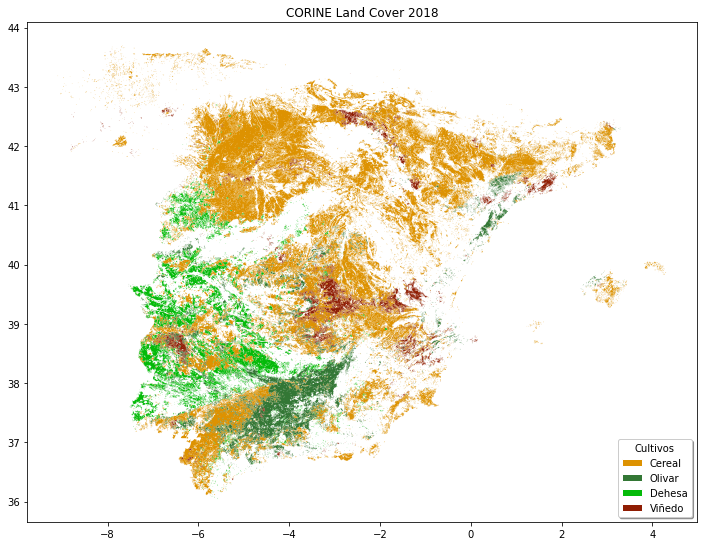

In [6]:
fig, ax = plt.subplots(figsize=(12,12))

gdf_corine[gdf_corine['CODE_18'].isin(['211', '212'])].plot(ax=ax, color='#DD9201', label= 'Cereal', legend=True)
gdf_corine[gdf_corine['CODE_18'].isin(['223'])].plot(ax=ax, color='#337735', label= 'Olivar', legend=True)
gdf_corine[gdf_corine['CODE_18'].isin(['244'])].plot(ax=ax, color='#04BA09', label= 'Dehesa', legend=True)
gdf_corine[gdf_corine['CODE_18'].isin(['221'])].plot(ax=ax, color='#8F1D03', label= 'Viñedo', legend=True)

ax.set_title('CORINE Land Cover 2018')

# Adding custom legend
pmark1 = mpatches.Patch(facecolor='#DD9201',
                       edgecolor='white',
                       linestyle='-',
                       alpha=1,
                       label='Cereal')

pmark2 = mpatches.Patch(facecolor='#337735',
                       edgecolor='white',
                       linestyle='-',
                       alpha=1,
                       label='Olivar')

pmark3 = mpatches.Patch(facecolor='#04BA09',
                       edgecolor='white',
                       linestyle='-',
                       alpha=1,
                       label='Dehesa')

pmark4 = mpatches.Patch(facecolor='#8F1D03',
                       edgecolor='white',
                       linestyle='-',
                       alpha=1,
                       label='Viñedo')

handles, _ = ax.get_legend_handles_labels()
ax.legend(
    handles=[
        *handles,
        pmark1,
        pmark2,
        pmark3,
        pmark4,
    ],
    title="Cultivos",
    loc='lower right',
    ncol=1,
    shadow=True)

# show figure
plt.rcParams['legend.title_fontsize'] = 10
plt.show()

# Rasterize vector data

To rasterize the polygons, we select only the categories of interest and convert them into integers

In [7]:
gdf_corine = gdf_corine[gdf_corine['CODE_18'].isin(['211', '212', '223', '244', '221'])].astype({'CODE_18': np.int32})

## Rasterize

We rasterize the polygons with the new property of value we added before. 

In addition, we set the spatial resolution to (-0.0005, 0.0005) along the Y and X directions.

In [8]:
ds_corine = make_geocube(
    vector_data=gdf_corine,
    measurements=['CODE_18', 'AREA_HA'],
    resolution=  (-0.001, 0.001)
)
ds_corine

<xarray.Dataset>
Dimensions:      (y: 7663, x: 13410)
Coordinates:
  * y            (y) float64 43.71 43.7 43.7 43.7 ... 36.05 36.05 36.04 36.04
  * x            (x) float64 -9.105 -9.104 -9.103 -9.102 ... 4.302 4.303 4.304
    spatial_ref  int64 0
Data variables:
    CODE_18      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    AREA_HA      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [9]:
lon_min, lat_min, lon_max, lat_max = (-9.39288367353, 35.946850084, 4.32841, 43.7483377142)

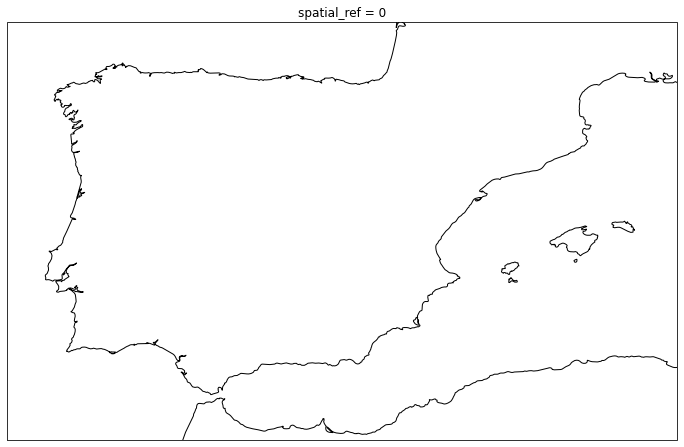

In [10]:
plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

cMap = colors.ListedColormap(['#DD9201'])
ds_corine['CODE_18'].where(ds_corine['CODE_18'] <= 212).plot.pcolormesh(ax=ax, cmap=cMap , transform=ccrs.PlateCarree(), x='x', y='y', add_colorbar=False)

cMap = colors.ListedColormap(['#337735'])
ds_corine['CODE_18'].where(ds_corine['CODE_18'] == 223).plot.pcolormesh(ax=ax, cmap=cMap , transform=ccrs.PlateCarree(), x='x', y='y', add_colorbar=False)

cMap = colors.ListedColormap(['#04BA09'])
ds_corine['CODE_18'].where(ds_corine['CODE_18'] == 244).plot.pcolormesh(ax=ax, cmap=cMap , transform=ccrs.PlateCarree(), x='x', y='y', add_colorbar=False)

cMap = colors.ListedColormap(['#8F1D03'])
ds_corine['CODE_18'].where(ds_corine['CODE_18'] == 221).plot.pcolormesh(ax=ax, cmap=cMap , transform=ccrs.PlateCarree(), x='x', y='y', add_colorbar=False)

ax.coastlines()
ax.set_ylim([lat_min-1,lat_max+1]);
ax.set_xlim([lon_min-1,lon_max+1]);